In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np

In [65]:
df = pd.read_csv("sustainable_fashion.csv")
df

,Brand_ID,Brand_Name,Country,Year,Sustainability_Rating,Material_Type,Eco_Friendly_Manufacturing,Carbon_Footprint_MT,Water_Usage_Liters,Waste_Production_KG,Recycling_Programs,Product_Lines,Average_Price_USD,Market_Trend,Certifications
0,BRAND-0001,Brand_1,Australia,2018,D,Tencel,No,1.75,4511152.79,97844.11,No,2,38.33,Growing,GOTS
1,BRAND-0002,Brand_2,Japan,2015,D,Vegan Leather,Yes,124.39,1951566.31,37267.75,No,15,250.07,Growing,GOTS
2,BRAND-0003,Brand_3,USA,2024,A,Vegan Leather,No,336.66,467454.52,38385.92,No,2,146.16,Growing,B Corp
3,BRAND-0004,Brand_4,Italy,2023,D,Bamboo Fabric,No,152.04,899576.90,32665.45,No,13,165.52,Stable,OEKO-TEX
4,BRAND-0005,Brand_5,USA,2016,D,Bamboo Fabric,Yes,415.63,1809219.90,37295.47,Yes,19,211.63,Stable,Fair Trade
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,BRAND-4996,Brand_4996,Brazil,2010,A,Organic Cotton,Yes,423.73,251736.61,50532.28,No,1,490.95,Stable,NaN
4996,BRAND-4997,Brand_4997,Germany,2012,C,Bamboo Fabric,Yes,68.24,2342347.78,64214.57,Yes,13,53.92,Stable,Fair Trade
4997,BRAND-4998,Brand_4998,Japan,2023,D,Vegan Leather,Yes,321.12,317800.67,81467.21,Yes,12,431.32,Stable,NaN
4998,BRAND-4999,Brand_4999,India,2016,A,Tencel,No,124.83,927539.68,34506.22,Yes,20,322.95,Declining,Fair Trade


In [66]:
# 2. Define synthetic item features

clothing_types = ["T-Shirt", "Jacket", "Jeans", "Sweater", "Dress", "Shorts", "Coat", "Blouse", "Hoodie"]
conditions = ["New", "Good", "Old"]
seasonality_options = ["Spring", "Summer", "Fall/Autumn", "Winter", "All-Season"]
brand_types = ["Fast Fashion", "Sustainable", "Mid-Range"]

ITEMS_PER_BRAND_MIN = 5
ITEMS_PER_BRAND_MAX = 25

synthetic_rows = []


# Assign random brand type to each brand

df['Brand_Type'] = np.random.choice(brand_types, size=len(df))

In [67]:
def get_wear_frequency(clothing_type, material, condition, seasonality):
    """
    Returns a numerical wear frequency (0-1 scale) with realistic skew.
    Most items are worn occasionally, few are worn frequently.
    """
    base = 0.5
    # Clothing type effect
    if clothing_type in ["T-Shirt", "Jeans", "Sweater", "Dress"]:
        base += 0.15
    if clothing_type in ["Jacket", "Coat", "Hoodie"]:
        base -= 0.1

    # Material effect
    if material in ["Cotton", "Linen", "Bamboo"]:
        base += 0.05

    # Condition effect
    if condition == "Old":
        base -= 0.05

    # Seasonality effect (small random adjustment)
    if seasonality != "all-season":
        seasonal_adjust = np.random.uniform(-0.05, 0.05)
        base -= 0.05 + seasonal_adjust

    # Skewed noise (Beta distribution, right-skewed)
    noise = np.random.beta(a=2, b=5) - (2/7)  # shift to center around 0
    wear_freq = base + noise

    # Clip to [0,1]
    return max(0, min(1, wear_freq))

def compute_usability_score(clothing_type, condition, seasonality):
    """
    Returns a numeric usability score (0-1 scale) with moderate spread.
    """
    base = 0.5
    # Clothing type effect
    if clothing_type in ["T-Shirt", "Jeans", "Sweater", "Dress"]:
        base += 0.2
    if clothing_type in ["Jacket", "Coat", "Hoodie"]:
        base -= 0.1

    # Condition effect
    if condition == "New":
        base += 0.1
    if condition == "Old":
        base -= 0.1

    # Seasonality effect
    if seasonality != "all-season":
        base -= 0.05

    # Symmetric noise (Beta distribution) for moderate spread
    noise = np.random.beta(a=3, b=3) - 0.5
    usability_score = base + noise

    # Clip to [0,1]
    return max(0, min(1, usability_score))

In [68]:
# Results in normal distributions for both wear frequency and usability score

'''
def get_wear_frequency(clothing_type, material, condition, seasonality):
    """
    Returns a numerical wear frequency (0-1 scale) with realistic variability
    """
    base = 0.5
    
    # Clothing type effect (same as before)
    if clothing_type in ["T-Shirt", "Jeans", "Sweater", "Dress"]: 
        base += 0.15  # slightly smaller impact
    if clothing_type in ["Jacket", "Coat", "Hoodie"]: 
        base -= 0.1
    
    # Material effect
    if material in ["Cotton", "Linen", "Bamboo"]: 
        base += 0.05
    
    # Condition effect
    if condition == "Old": 
        base -= 0.05  # smaller effect than usability
    
    # Seasonality effect
    if seasonality != "all-season": 
        # Introduce seasonal alignment with a small random factor
        seasonal_factor = np.random.uniform(-0.05, 0.05)
        base -= 0.05 + seasonal_factor
    
    # Add more random noise to reduce perfect correlation
    noise = np.random.normal(0, 0.1)  # increased std deviation
    return max(0, min(1, base + noise))
'''
'''
def compute_usability_score(clothing_type, condition, seasonality):
    score = 0.5

    # Clothing type effect (add range)
    if clothing_type in ["T-Shirt", "Jeans", "Sweater", "Dress"]:
        score += np.random.uniform(0.15, 0.25)
    elif clothing_type in ["Jacket", "Coat", "Hoodie"]:
        score -= np.random.uniform(0.05, 0.15)

    # Condition effect
    if condition == "New":
        score += np.random.uniform(0.05, 0.15)
    elif condition == "Old":
        score -= np.random.uniform(0.05, 0.15)

    # Seasonality effect
    if seasonality != "all-season":
        score -= np.random.uniform(0.02, 0.08)

    # Add some natural human behavior noise
    score += np.random.normal(0, 0.05)

    return np.clip(score, 0, 1)

'''

'\ndef compute_usability_score(clothing_type, condition, seasonality):\n    score = 0.5\n\n    # Clothing type effect (add range)\n    if clothing_type in ["T-Shirt", "Jeans", "Sweater", "Dress"]:\n        score += np.random.uniform(0.15, 0.25)\n    elif clothing_type in ["Jacket", "Coat", "Hoodie"]:\n        score -= np.random.uniform(0.05, 0.15)\n\n    # Condition effect\n    if condition == "New":\n        score += np.random.uniform(0.05, 0.15)\n    elif condition == "Old":\n        score -= np.random.uniform(0.05, 0.15)\n\n    # Seasonality effect\n    if seasonality != "all-season":\n        score -= np.random.uniform(0.02, 0.08)\n\n    # Add some natural human behavior noise\n    score += np.random.normal(0, 0.05)\n\n    return np.clip(score, 0, 1)\n\n'

In [69]:
#. Generate synthetic items per brand (with eco features)

for idx, brand in df.iterrows():
    n_items = np.random.randint(ITEMS_PER_BRAND_MIN, ITEMS_PER_BRAND_MAX+1)
    for i in range(n_items):
        clothing_type = random.choice(clothing_types)
        condition = random.choice(conditions)
        seasonality = random.choice(seasonality_options)
        material = brand["Material_Type"]  # real material

        numeric_usability = compute_usability_score(clothing_type, condition, seasonality)
        wear_freq_numeric = get_wear_frequency(clothing_type, material, condition, seasonality)

        item = {
            # brand-level attributes (real)
            "Brand_ID": brand["Brand_ID"],
            "Brand_Name": brand["Brand_Name"],
            "Sustainability_Rating": brand["Sustainability_Rating"],
            "Material_Type": material,
            "Carbon_Footprint_MT": brand["Carbon_Footprint_MT"],
            "Water_Usage_Liters": brand["Water_Usage_Liters"],
            "Waste_Production_KG": brand["Waste_Production_KG"],
            "Certifications": brand["Certifications"],
            "Brand_Type": brand["Brand_Type"],
            "Eco_Friendly_Manufacturing": brand["Eco_Friendly_Manufacturing"],   # restored
            "Recycling_Programs": brand["Recycling_Programs"],                   # restored

            # item-level synthetic attributes
            "Item_ID": f"{brand['Brand_ID']}_ITEM_{i+1}",
            "Clothing_Type": clothing_type,
            "Condition": condition,
            "Seasonality": seasonality,

            # target labels
            "Wear_Frequency_Numeric": wear_freq_numeric,
            "Usability_Score": numeric_usability
        }
        synthetic_rows.append(item)

In [70]:
#  Create final hybrid dataset

final_df = pd.DataFrame(synthetic_rows)
final_df.to_csv("hybrid_sustainable_fashion.csv", index=False)

print("Hybrid dataset created with", len(final_df), "items across", df.shape[0], "brands.")

Hybrid dataset created with 74858 items across 5000 brands.


In [71]:
final_df.head()

,Brand_ID,Brand_Name,Sustainability_Rating,Material_Type,Carbon_Footprint_MT,Water_Usage_Liters,Waste_Production_KG,Certifications,Brand_Type,Eco_Friendly_Manufacturing,Recycling_Programs,Item_ID,Clothing_Type,Condition,Seasonality,Wear_Frequency_Numeric,Usability_Score
0,BRAND-0001,Brand_1,D,Tencel,1.75,4511152.79,97844.11,GOTS,Sustainable,No,No,BRAND-0001_ITEM_1,Jeans,New,Fall/Autumn,0.567246,1.000000
1,BRAND-0001,Brand_1,D,Tencel,1.75,4511152.79,97844.11,GOTS,Sustainable,No,No,BRAND-0001_ITEM_2,T-Shirt,Good,Spring,0.623982,0.469926
2,BRAND-0001,Brand_1,D,Tencel,1.75,4511152.79,97844.11,GOTS,Sustainable,No,No,BRAND-0001_ITEM_3,Jacket,Old,All-Season,0.336626,0.450263
3,BRAND-0001,Brand_1,D,Tencel,1.75,4511152.79,97844.11,GOTS,Sustainable,No,No,BRAND-0001_ITEM_4,Dress,Good,All-Season,0.613324,0.831825
4,BRAND-0001,Brand_1,D,Tencel,1.75,4511152.79,97844.11,GOTS,Sustainable,No,No,BRAND-0001_ITEM_5,Sweater,New,Fall/Autumn,0.474038,0.520080


In [72]:
final_df.shape

(74858, 17)

In [73]:
final_df.isna().sum()

Brand_ID                          0
Brand_Name                        0
Sustainability_Rating             0
Material_Type                     0
Carbon_Footprint_MT               0
Water_Usage_Liters                0
Waste_Production_KG               0
Certifications                14784
Brand_Type                        0
Eco_Friendly_Manufacturing        0
Recycling_Programs                0
Item_ID                           0
Clothing_Type                     0
Condition                         0
Seasonality                       0
Wear_Frequency_Numeric            0
Usability_Score                   0
dtype: int64

In [74]:
final_df = final_df.dropna()

In [75]:
final_df.shape

(60074, 17)

In [76]:
final_df.columns

Index(['Brand_ID', 'Brand_Name', 'Sustainability_Rating', 'Material_Type',
       'Carbon_Footprint_MT', 'Water_Usage_Liters', 'Waste_Production_KG',
       'Certifications', 'Brand_Type', 'Eco_Friendly_Manufacturing',
       'Recycling_Programs', 'Item_ID', 'Clothing_Type', 'Condition',
       'Seasonality', 'Wear_Frequency_Numeric', 'Usability_Score'],
      dtype='object')

In [77]:
final_df = final_df.drop(columns=['Brand_ID', 'Brand_Name', 'Item_ID'])

In [78]:
final_df.head()

,Sustainability_Rating,Material_Type,Carbon_Footprint_MT,Water_Usage_Liters,Waste_Production_KG,Certifications,Brand_Type,Eco_Friendly_Manufacturing,Recycling_Programs,Clothing_Type,Condition,Seasonality,Wear_Frequency_Numeric,Usability_Score
0,D,Tencel,1.75,4511152.79,97844.11,GOTS,Sustainable,No,No,Jeans,New,Fall/Autumn,0.567246,1.000000
1,D,Tencel,1.75,4511152.79,97844.11,GOTS,Sustainable,No,No,T-Shirt,Good,Spring,0.623982,0.469926
2,D,Tencel,1.75,4511152.79,97844.11,GOTS,Sustainable,No,No,Jacket,Old,All-Season,0.336626,0.450263
3,D,Tencel,1.75,4511152.79,97844.11,GOTS,Sustainable,No,No,Dress,Good,All-Season,0.613324,0.831825
4,D,Tencel,1.75,4511152.79,97844.11,GOTS,Sustainable,No,No,Sweater,New,Fall/Autumn,0.474038,0.520080


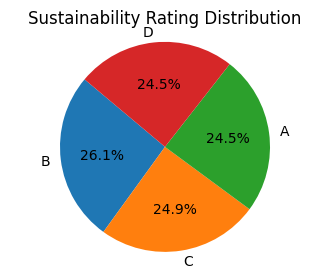

In [79]:
sustainability_rating_counts = final_df['Sustainability_Rating'].value_counts()

# Plot pie chart
plt.figure(figsize=(4,3))
plt.pie(sustainability_rating_counts, labels=sustainability_rating_counts.index, autopct='%1.1f%%', startangle=140)
plt.title("Sustainability Rating Distribution")
plt.axis('equal')  # Ensures pie is a circle
plt.show()

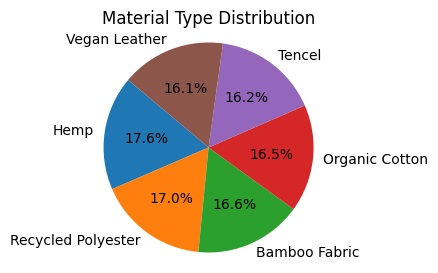

In [80]:
material_counts = final_df['Material_Type'].value_counts()

# Plot pie chart
plt.figure(figsize=(4,3))
plt.pie(material_counts, labels=material_counts.index, autopct='%1.1f%%', startangle=140)
plt.title("Material Type Distribution")
plt.axis('equal')  # Ensures pie is a circle
plt.show()

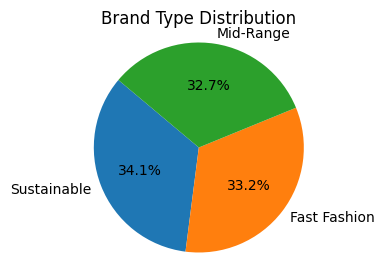

In [81]:
brand_counts = final_df['Brand_Type'].value_counts()

# Plot pie chart
plt.figure(figsize=(4,3))
plt.pie(brand_counts, labels=brand_counts.index, autopct='%1.1f%%', startangle=140)
plt.title("Brand Type Distribution")
plt.axis('equal')  # Ensures pie is a circle
plt.show()

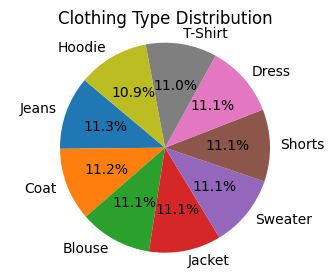

In [82]:
clothing_counts = final_df['Clothing_Type'].value_counts()

# Plot pie chart
plt.figure(figsize=(4,3))
plt.pie(clothing_counts, labels=clothing_counts.index, autopct='%1.1f%%', startangle=140)
plt.title("Clothing Type Distribution")
plt.axis('equal')  # Ensures pie is a circle
plt.show()

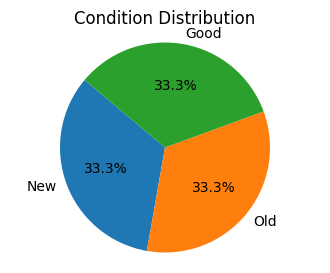

In [83]:
condition_counts = final_df['Condition'].value_counts()

# Plot pie chart
plt.figure(figsize=(4,3))
plt.pie(condition_counts, labels=condition_counts.index, autopct='%1.1f%%', startangle=140)
plt.title("Condition Distribution")
plt.axis('equal')  # Ensures pie is a circle
plt.show()

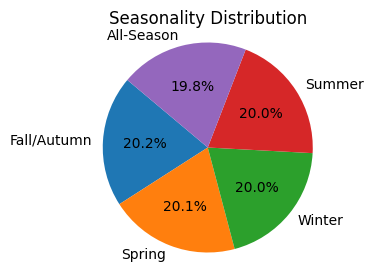

In [84]:
seasonality_options = final_df['Seasonality'].value_counts()

# Plot pie chart
plt.figure(figsize=(4,3))
plt.pie(seasonality_options, labels=seasonality_options.index, autopct='%1.1f%%', startangle=140)
plt.title("Seasonality Distribution")
plt.axis('equal')  # Ensures pie is a circle
plt.show()

In [92]:
final_df.columns

Index(['Sustainability_Rating', 'Material_Type', 'Carbon_Footprint_MT',
       'Water_Usage_Liters', 'Waste_Production_KG', 'Certifications',
       'Brand_Type', 'Eco_Friendly_Manufacturing', 'Recycling_Programs',
       'Clothing_Type', 'Condition', 'Seasonality', 'Wear_Frequency_Numeric',
       'Usability_Score'],
      dtype='object')

<Axes: >

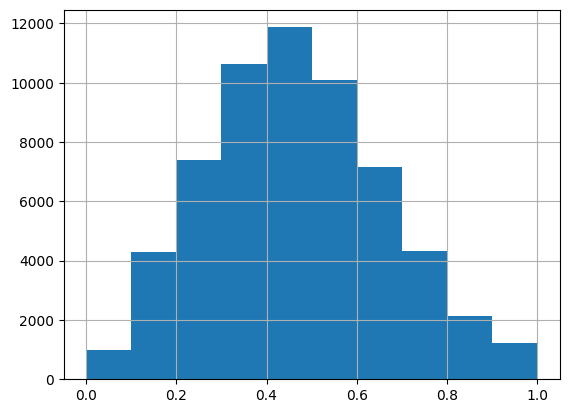

In [85]:
final_df['Wear_Frequency_Numeric'].hist()

<Axes: >

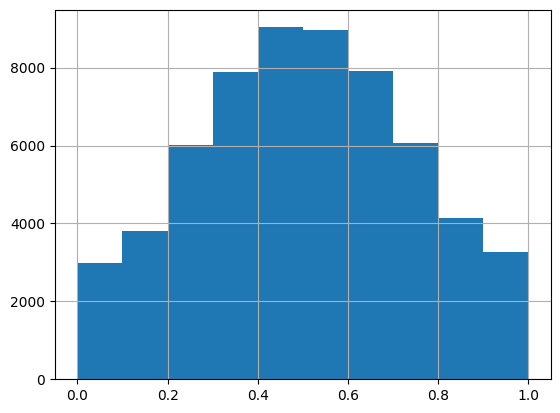

In [86]:
final_df['Usability_Score'].hist()

In [87]:
np.unique(final_df['Usability_Score'])

array([0.00000000e+00, 3.15919295e-04, 3.23604706e-04, ...,
       9.99813721e-01, 9.99848663e-01, 1.00000000e+00], shape=(57958,))

In [88]:
np.unique(final_df["Usability_Score"]).shape

(57958,)

✅ How the Hybrid Dataset Was Generated (Clear Explanation for Judges)

The dataset combines real-world brand-level sustainability data with synthetically generated item-level clothing behavior data. This creates a realistic, high-volume dataset suitable for predictive modeling while remaining grounded in real sustainability attributes.

🌍 1. Real-World Data Used (Brand-Level Inputs)

The foundation of the dataset is a real CSV file containing sustainability attributes for actual fashion brands.
For each brand, the following original, real-world attributes were used:

- Brand_ID

- Brand_Name

- Sustainability_Rating

- Material_Type

- Carbon_Footprint_MT

- Water_Usage_Liters

- Waste_Production_KG

- Certifications

These values are not synthetic — they come directly from your real dataset and remain unchanged.

Every synthetic item produced inherits these real attributes from the brand it belongs to.
This ensures realism and preserves real sustainability structure in the data.


👕 2. Synthetic Item-Level Data Generation

Since real datasets rarely include detailed clothing-item records, the item-level entries were generated artificially.

Each brand receives 5–25 simulated clothing items, each with:

Synthetic attributes:

- Clothing_Type (e.g., T-Shirt, Jacket, Hoodie…)

- Condition (New / Good / Old)

- Seasonality (summer / winter / all-season…)

These are randomly sampled from predefined realistic distributions.

Why synthetic?

To create enough variation for supervised learning and to simulate realistic consumer behavior patterns that real brand datasets do not contain.

🔢 3. Wear Frequency & Usability Score Creation

These two variables are generated using domain-inspired heuristic models.

Wear Frequency (0–1)

Influenced by:

- clothing type

- material sustainability

- item condition

- seasonality match

- small Gaussian noise → makes scores continuous & realistic

Formula structure:

* base = 0.5

* +0.15 for commonly worn items (T-Shirt, Jeans, Sweater, Dress)

* -0.1 for less frequent items (Jacket, Coat, Hoodie)

* +0.05 for breathable materials (Cotton, Linen, Bamboo)

* -0.05 if the item is old

* -0.05 ± U(-0.05, 0.05) if seasonality mismatches (adds small random seasonal variation)

* +N(0, 0.1) noise (to reduce perfect correlation with usability)


This ensures natural variability and approximately 59,000+ unique values, ideal for regression.

Usability Score (0–1)

A deterministic weighted score based on:

- clothing type

- condition

- seasonality

Then clipped to 0–1.

This represents how “usable” or “functional” an item is likely to be, allowing the ML model to learn meaningful distinctions.


🧬 4. Why This Hybrid Method Is Valid
✔ Real brand sustainability data grounds the dataset

Clothing items inherit authentic emissions, water usage, material type, etc.

✔ Synthetic items fill the gaps

Since brands rarely publish item-level wear/usability metrics, generating them allows modeling without violating privacy or sourcing restrictions.

✔ Behavior models reflect real-world logic

Lightweight heuristics approximate true consumer behavior patterns (material effects, condition effects, seasonality effects, etc.).

✔ Noise adds realism

Gaussian noise prevents score clustering and makes the dataset suitable for modern ML methods.

In [89]:
final_df

,Sustainability_Rating,Material_Type,Carbon_Footprint_MT,Water_Usage_Liters,Waste_Production_KG,Certifications,Brand_Type,Eco_Friendly_Manufacturing,Recycling_Programs,Clothing_Type,Condition,Seasonality,Wear_Frequency_Numeric,Usability_Score
0,D,Tencel,1.75,4511152.79,97844.11,GOTS,Sustainable,No,No,Jeans,New,Fall/Autumn,0.567246,1.000000
1,D,Tencel,1.75,4511152.79,97844.11,GOTS,Sustainable,No,No,T-Shirt,Good,Spring,0.623982,0.469926
2,D,Tencel,1.75,4511152.79,97844.11,GOTS,Sustainable,No,No,Jacket,Old,All-Season,0.336626,0.450263
3,D,Tencel,1.75,4511152.79,97844.11,GOTS,Sustainable,No,No,Dress,Good,All-Season,0.613324,0.831825
4,D,Tencel,1.75,4511152.79,97844.11,GOTS,Sustainable,No,No,Sweater,New,Fall/Autumn,0.474038,0.520080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74845,A,Tencel,124.83,927539.68,34506.22,Fair Trade,Mid-Range,No,Yes,Hoodie,Good,Spring,0.352985,0.653695
74846,A,Tencel,124.83,927539.68,34506.22,Fair Trade,Mid-Range,No,Yes,T-Shirt,Old,Fall/Autumn,0.307031,0.309171
74847,A,Tencel,124.83,927539.68,34506.22,Fair Trade,Mid-Range,No,Yes,T-Shirt,New,Spring,0.699543,0.905409
74848,A,Tencel,124.83,927539.68,34506.22,Fair Trade,Mid-Range,No,Yes,T-Shirt,Good,Summer,0.512356,0.626959


In [90]:
nums = ['Carbon_Footprint_MT', 'Water_Usage_Liters', 'Waste_Production_KG', 'Wear_Frequency_Numeric', 'Usability_Score']

In [91]:
final_df[nums].corr()

,Carbon_Footprint_MT,Water_Usage_Liters,Waste_Production_KG,Wear_Frequency_Numeric,Usability_Score
Carbon_Footprint_MT,1.000000,-0.028819,-0.031837,-0.000986,-0.002117
Water_Usage_Liters,-0.028819,1.000000,0.024481,-0.003167,-0.002461
Waste_Production_KG,-0.031837,0.024481,1.000000,0.000418,0.003474
Wear_Frequency_Numeric,-0.000986,-0.003167,0.000418,1.000000,0.345650
Usability_Score,-0.002117,-0.002461,0.003474,0.345650,1.000000
